In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn import model_selection, preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, log_loss

C:\Users\dulm\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline
pd.set_option('display.max_columns', 100)

In [3]:
train_df = pd.read_json('../data/train.json')
test_df = pd.read_json('../data/test.json')

In [4]:
len(train_df)

49352

In [5]:
train_df

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],medium,40.7429,6894514,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street
100016,1.0,2,3ba49a93260ca5df92fde024cb4ca61f,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,"[prewar, elevator, Dogs Allowed, Cats Allowed,...",low,40.8012,6930771,-73.9660,01287194f20de51872e81f660def4784,[https://photos.renthop.com/2/6930771_7e3622b6...,3600,210 West 107th Street
100020,2.0,1,0372927bcb6a0949613ef5bf893bbac7,2016-04-13 06:01:42,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,"[Doorman, Elevator, Pre-War, Terrace, Laundry ...",low,40.7427,6867392,-73.9957,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/6867392_b18283f6...,5645,155 West 21st Street
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",medium,40.8234,6898799,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace
100027,2.0,4,0,2016-04-02 02:58:15,This is a spacious four bedroom with every bed...,522 E 11th,"[Dishwasher, Hardwood Floors]",low,40.7278,6814332,-73.9808,23a01ea7717b38875f5b070282d1b9d2,[https://photos.renthop.com/2/6814332_e19a8552...,5800,522 E 11th


In [6]:
def get_basic_features(train_df):
    basic_features = pd.DataFrame(index=train_df.index)
    
    basic_features['bathrooms'] = train_df['bathrooms']
    basic_features['bedrooms'] = train_df['bedrooms']
    
    basic_features['price'] = train_df['price']
    
    basic_features["num_photos"] = train_df["photos"].apply(len)
    basic_features["num_features"] = train_df["features"].apply(len)
    basic_features["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
    
    created = pd.to_datetime(train_df["created"])
    
    basic_features["created_year"] = created.dt.year
    basic_features["created_month"] = created.dt.month
    basic_features["created_day"] = created.dt.day
    
    return basic_features

In [27]:
def get_geo_featues(train_df, test_df):
    mean_latitude = pd.concat([train_df['latitude'], test_df['latitude']]).mean()
    mean_longitude = pd.concat([train_df['longitude'], test_df['longitude']]).mean()
    
    train_geo = train_df[['latitude', 'longitude']]\
        .apply(lambda r: np.sqrt(np.power(r['latitude'] - mean_latitude, 2) + np.power(r['longitude'] - mean_longitude, 2)), axis=1)
    test_geo = test_df[['latitude', 'longitude']]\
        .apply(lambda r: np.sqrt(np.power(r['latitude'] - mean_latitude, 2) + np.power(r['longitude'] - mean_longitude, 2)), axis=1)

    train_geo.name = test_geo.name = 'distance from center'
        
    return pd.concat([train_geo, train_df[['latitude', 'longitude']]], axis=1), \
        pd.concat([test_geo, test_df[['latitude', 'longitude']]], axis=1)

In [8]:
def get_flat_features(train_df, test_df):
    import operator
    from collections import Counter
    
    counter = Counter()
    for _, item in train_df['features'].iteritems():
        counter.update(item)
        
    for _, item in test_df['features'].iteritems():
        counter.update(item)
        
    most_popular_features = \
        [k for k, v in sorted(counter.items(), key=operator.itemgetter(1), reverse=True)][:60]
    
    print(most_popular_features)
    
    # TODO: refactor
    train_features_str = train_df['features'].apply(lambda f: '|'.join(f))
    train_flat_features = pd.concat(
        [train_features_str.str.contains(f).rename(f) for f in most_popular_features],
        axis=1)
    
    test_features_str = test_df['features'].apply(lambda f: '|'.join(f))
    test_flat_features = pd.concat(
        [test_features_str.str.contains(f).rename(f) for f in most_popular_features],
        axis=1)
    
    return train_flat_features, test_flat_features

In [9]:
def get_encoded_categorical(train_df, test_df):
    categorical_features = ["display_address", "manager_id", "building_id", "street_address"]

    train_categorical = pd.DataFrame(index=train_df.index)
    test_categorical = pd.DataFrame(index=test_df.index)
    for f in categorical_features:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values) + list(test_df[f].values))
        
        train_categorical[f] = lbl.transform(list(train_df[f].values))
        test_categorical[f] = lbl.transform(list(test_df[f].values))
    
    return train_categorical, test_categorical

In [10]:
def get_manager_features(train_df, test_df):
    temp = pd.concat([train_df['manager_id'], pd.get_dummies(train_df['interest_level'])], axis = 1) \
        .groupby('manager_id').mean()
    temp.columns = ['high_frac','low_frac', 'medium_frac']
    temp['count'] = train_df.groupby('manager_id').count().iloc[:,1]

    temp['manager_skill'] = temp['high_frac'] * 2 + temp['medium_frac']
    
    ranked_managers_ixes = temp['count'] >= 20

    mean_values = temp.loc[ranked_managers_ixes, 'manager_skill'].mean()
    temp.loc[ranked_managers_ixes, 'manager_skill'] = mean_values
    
    train_managers = pd.merge(train_df, temp, left_on='manager_id', right_index=True, how='left')['manager_skill']
    test_managers = pd.merge(test_df, temp, left_on='manager_id', right_index=True, how='left')['manager_skill']
    
    test_managers.fillna(mean_values, inplace=True)
    
    return train_managers, test_managers

In [11]:
def get_building_tops(train_df, test_df):
    buildings_count = pd.concat([train_df['building_id'], train_df['building_id']]).value_counts()

    train_features = pd.DataFrame(index=train_df.index)
    test_features = pd.DataFrame(index=test_df.index)
    
    for top in [1, 2, 5, 10, 15, 20, 25, 30, 50]:
        train_features['top_{}_building'.format(top)] = train_df['building_id'] \
            .apply(lambda x: 1 if x in buildings_count.index.values[buildings_count.values >= np.percentile(buildings_count.values, 100-top)] else 0)
        test_features['top_{}_building'.format(top)] = test_df['building_id'] \
            .apply(lambda x: 1 if x in buildings_count.index.values[buildings_count.values >= np.percentile(buildings_count.values, 100-top)] else 0)
    
    return train_features, test_features

In [12]:
def get_manager_tops(train_df, test_df):
    managers_count = pd.concat([train_df['manager_id'], train_df['manager_id']]).value_counts()

    train_features = pd.DataFrame(index=train_df.index)
    test_features = pd.DataFrame(index=test_df.index)
    
    for top in [1, 2, 5, 10, 15, 20, 25, 30, 50]:
        train_features['top_{}_manager'.format(top)] = train_df['manager_id'] \
            .apply(lambda x: 1 if x in managers_count.index.values[managers_count.values >= np.percentile(managers_count.values, 100-top)] else 0)
        test_features['top_{}_manager'.format(top)] = test_df['manager_id'] \
            .apply(lambda x: 1 if x in managers_count.index.values[managers_count.values >= np.percentile(managers_count.values, 100-top)] else 0)
    
    return train_features, test_features

In [13]:
def get_managers_expirience(train_df, test_df):
    managers_count = pd.concat([train_df['manager_id'], train_df['manager_id']]).value_counts()
    managers_count = managers_count.apply(np.log)
    
    train_exp = train_df['manager_id'].map(managers_count)
    test_exp = test_df['manager_id'].map(managers_count)
    
    train_exp.name = test_exp.name = 'manager_expirience'
    
    return train_exp, test_exp 

In [19]:
train_basic_features = get_basic_features(train_df)
test_basic_features = get_basic_features(test_df)
train_flat_features, test_flat_features = get_flat_features(train_df, test_df)
train_cat, test_cat = get_encoded_categorical(train_df, test_df)
# train_managers, test_managers = get_manager_features(train_df, test_df)
# train_buildings, test_buildings = get_building_tops(train_df, test_df)
# train_managers, test_managers = get_manager_tops(train_df, test_df)
train_managers, test_managers = get_managers_expirience(train_df, test_df)
train_geo, test_geo = get_geo_featues(train_df, test_df)

['Elevator', 'Cats Allowed', 'Hardwood Floors', 'Dogs Allowed', 'Doorman', 'Dishwasher', 'No Fee', 'Laundry in Building', 'Fitness Center', 'Pre-War', 'Laundry in Unit', 'Roof Deck', 'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Balcony', 'Swimming Pool', 'Laundry In Building', 'New Construction', 'Terrace', 'Exclusive', 'Loft', 'Garden/Patio', 'Wheelchair Access', 'Common Outdoor Space', 'HARDWOOD', 'SIMPLEX', 'Fireplace', 'prewar', 'LOWRISE', 'Laundry In Unit', 'Garage', 'Reduced Fee', 'Laundry Room', 'Furnished', 'Multi-Level', 'Private Outdoor Space', 'Prewar', 'Parking Space', 'PublicOutdoor', 'Roof-deck', 'dishwasher', 'High Ceilings', 'elevator', 'Renovated', 'Pool', 'LAUNDRY', 'HIGH CEILINGS', 'Green Building', 'LIVE IN SUPER', 'High Ceiling', 'Stainless Steel Appliances', 'Dryer in Unit', 'Washer in Unit', 'Concierge', 'On-site laundry', 'Storage', 'Newly renovated', 'Live In Super', 'On-site Laundry']


In [20]:
X = pd.concat([train_basic_features, train_geo, train_flat_features, train_cat, train_managers], axis=1)

In [21]:
y = train_df['interest_level'].map({'high':0, 'medium':1, 'low':2})

In [22]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [23]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.7)

### evaluation

In [24]:
cv_scores = []

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)

for dev_index, val_index in kf.split(train_X):
    dev_X = train_X.iloc[dev_index] 
    dev_y = train_y.iloc[dev_index]
    val_X = train_X.iloc[val_index]
    val_y = train_y.iloc[val_index]
    
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))

[0]	train-mlogloss:1.03771	test-mlogloss:1.03942
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:0.988105	test-mlogloss:0.991554
[2]	train-mlogloss:0.943168	test-mlogloss:0.948766
[3]	train-mlogloss:0.903291	test-mlogloss:0.910677
[4]	train-mlogloss:0.871063	test-mlogloss:0.879885
[5]	train-mlogloss:0.842399	test-mlogloss:0.852667
[6]	train-mlogloss:0.816793	test-mlogloss:0.828764
[7]	train-mlogloss:0.792644	test-mlogloss:0.806049
[8]	train-mlogloss:0.771677	test-mlogloss:0.786278
[9]	train-mlogloss:0.753494	test-mlogloss:0.769385
[10]	train-mlogloss:0.736856	test-mlogloss:0.754023
[11]	train-mlogloss:0.722877	test-mlogloss:0.741399
[12]	train-mlogloss:0.710509	test-mlogloss:0.730245
[13]	train-mlogloss:0.698594	test-mlogloss:0.719636
[14]	train-mlogloss:0.688125	test-mlogloss:0.710382
[15]	train-mlogloss:0.679014	test-mlogloss:0.70231
[16]	train-mlogloss:0.669728	t

0.557644612033 0.00659181762005


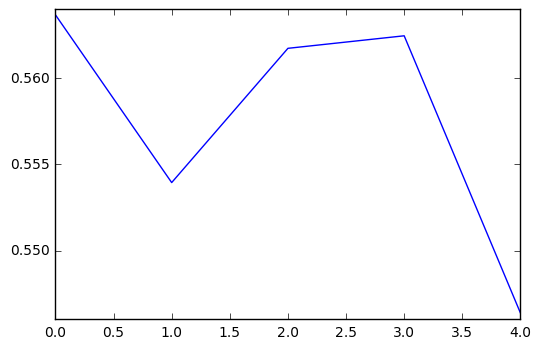

In [31]:
plt.plot(cv_scores)
print(np.mean(cv_scores), np.std(cv_scores))

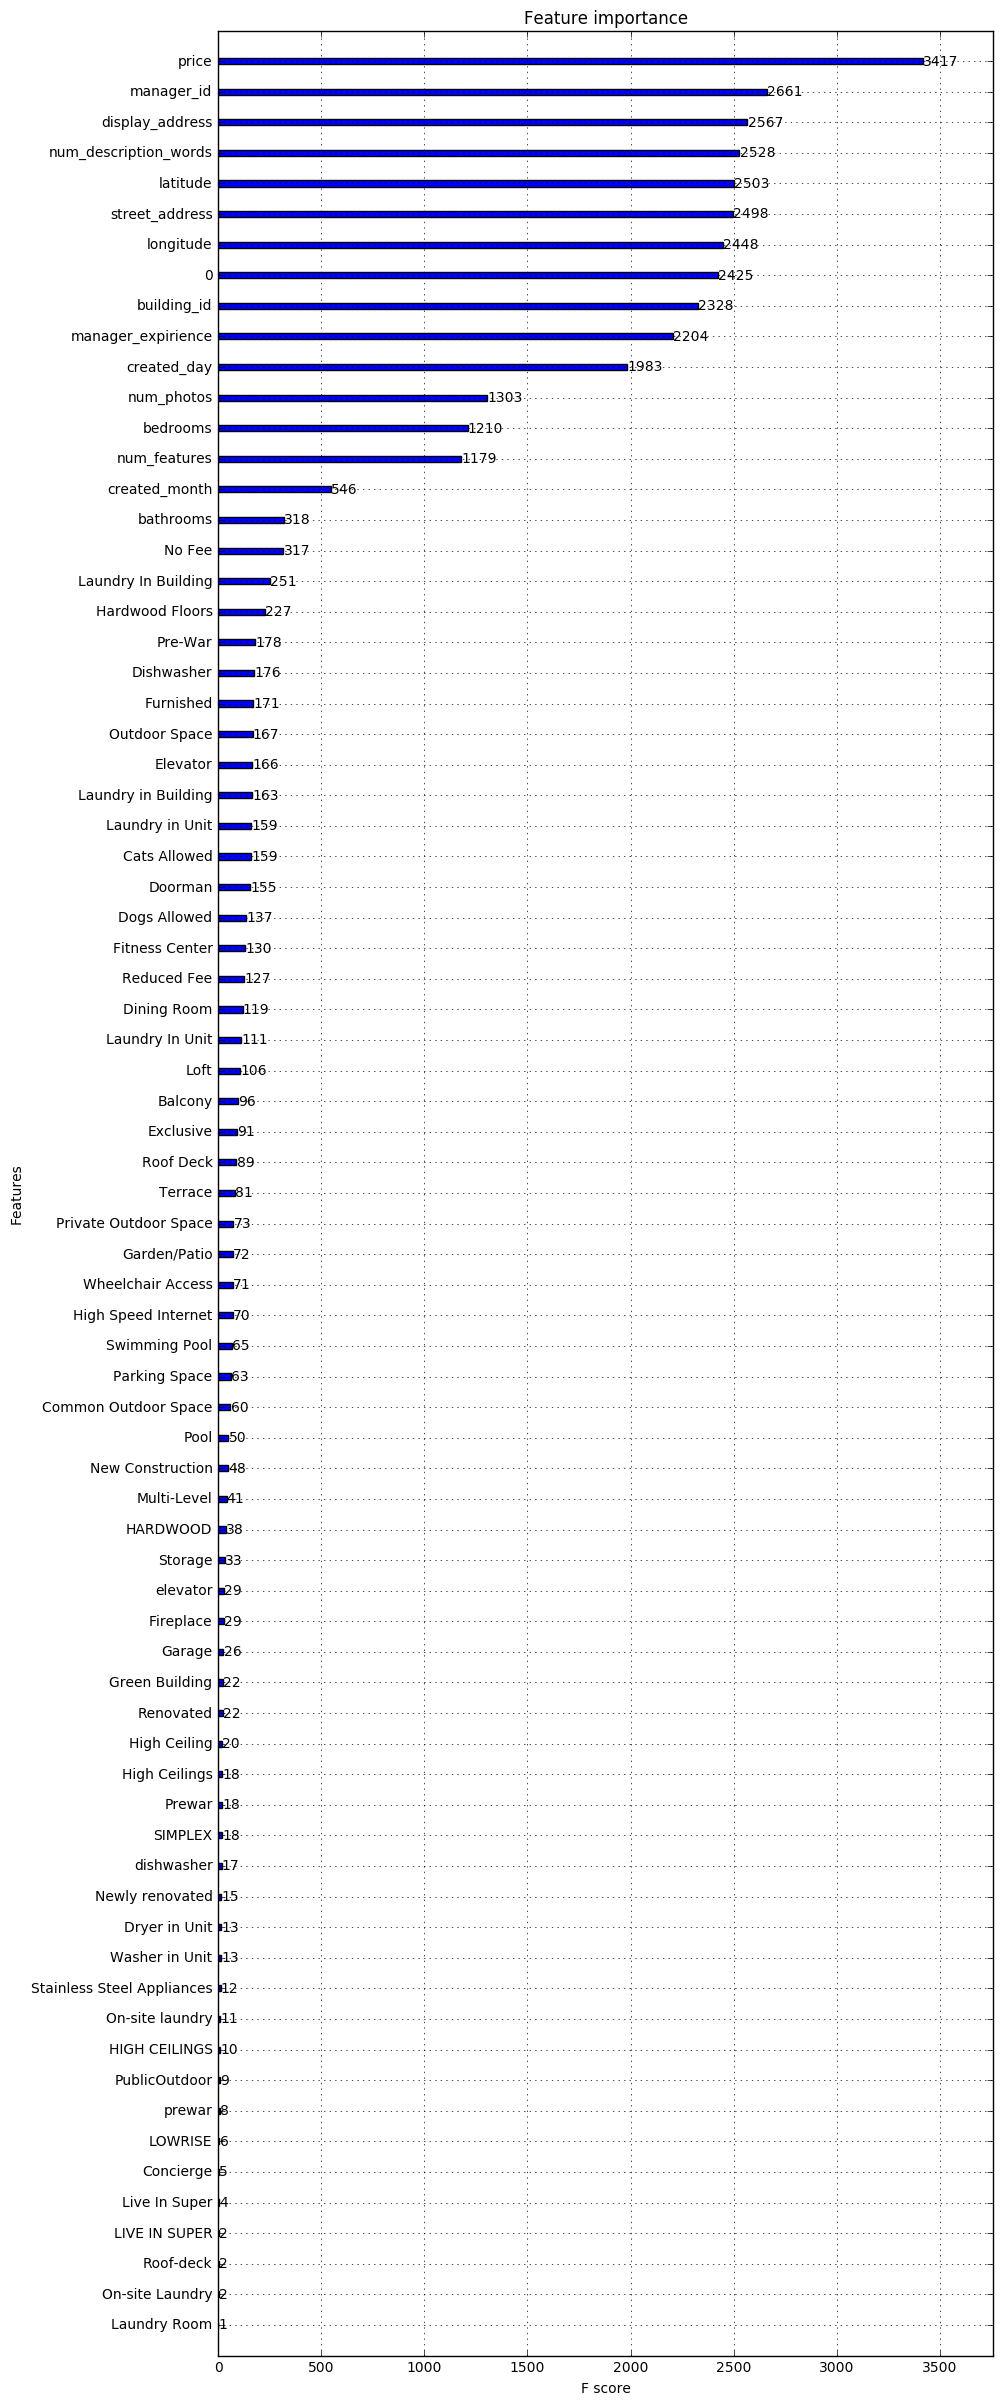

In [26]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10, 30))
plot_importance(model, ax=ax)

### create submission

In [28]:
pred_test, model = runXGB(X, y, 
                          pd.concat([test_basic_features, test_geo, test_flat_features, test_cat, test_managers], axis=1), 
                          num_rounds=280)

In [29]:
pred_test

array([[ 0.05574022,  0.48617882,  0.45808098],
       [ 0.03255297,  0.03701658,  0.93043041],
       [ 0.02655088,  0.22730307,  0.74614602],
       ..., 
       [ 0.05720619,  0.44906262,  0.49373117],
       [ 0.41929552,  0.43819061,  0.14251389],
       [ 0.02183791,  0.13173759,  0.84642452]], dtype=float32)

In [30]:
sub = pd.DataFrame(pred_test)
sub.columns = ["high", "medium", "low"]
sub["listing_id"] = test_df.listing_id.values
sub.to_csv("sub_xgb.csv", index=False)